# Structure Search

## Objectives
- Learn various types of structure searches including identity search, similarity search, substructure and super structure searches.
- Learn the optional parameters available for each search type.


Using PUG-REST, one can perform various types of structure searches (https://bit.ly/2lPznCo), including:
- identity search
- similarity search
- super/substructure search
- molecular formula search
<br>

As explained in a PubChem paper (https://bit.ly/2kirxky), whereas structure search can be performed in either an 'asynchronous' or 'synchronous' way, it is highly recommended to use the synchronous approach.<br>
The synchronous searches are invoked by using the keywords prefixed with ‘fast’, such as **fastidenity**, **fastsimilarity_2d**, **fastsimilarity_3d**, **fastsubstructure**, **fastsuperstructure**, and **fastformula**.

<div class="alert alert-block alert-warning">
Note: To use the python code in this lesson plan, RDKit must be installed on the system. 
</div>

Many users can simply run the following code to install RDKit.

Access to the full installation instructions can be found at the following link.
https://www.rdkit.org/docs/Install.html

## 1. Identity Search

PUG-REST allows you to search the PubChem Compound database for molecules identical to the query molecule.  PubChem's identity search supports different contexts of chemical identity, which the user can specify using the optional parameter, "identity_type".  Here are some commonly-used chemical identity contexts.
- **same_connectivity**: returns compounds with the same atom connectivity as the query molecule, ignoring stereochemistry and isotope information.
- **same_isotope**: returns compounds with the same isotopes (as well as the same atom connectivity) as the query molecule.  Stereochemistry will be ignored.
- **same_stereo**: returns compounds with the same stereochemistry (as well as the same atom connectivity) as the query molecule.  Isotope information will be ignored.
- **same_stereo_isotope**: returns compounds with the same stereochemistry AND isotope information (as well as the same atom connectivity).  This is the default.

The following code cell demostrates how these different contexts of chemical sameness affects identity search in PubChem.

#### Identity_type: same_stereo_isotope
24726 "C(/C=C/Cl)Cl"


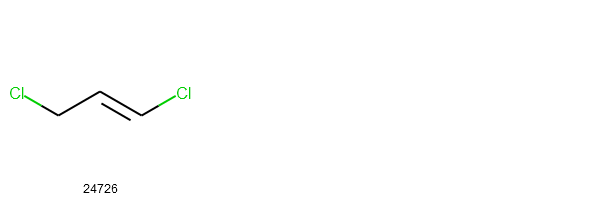

#### Identity_type: same_stereo
24726 "C(/C=C/Cl)Cl"
102602172 "[2H]/C(=C(/[2H])\Cl)/C([2H])([2H])Cl"


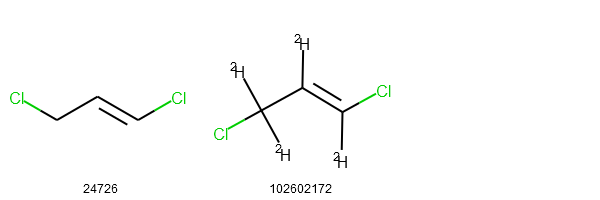

#### Identity_type: same_isotope
24726 "C(/C=C/Cl)Cl"
24883 "C(C=CCl)Cl"
5280970 "C(/C=C\Cl)Cl"


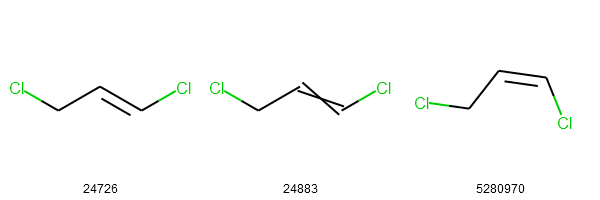

#### Identity_type: same_connectivity
24726 "C(/C=C/Cl)Cl"
24883 "C(C=CCl)Cl"
5280970 "C(/C=C\Cl)Cl"
102602172 "[2H]/C(=C(/[2H])\Cl)/C([2H])([2H])Cl"
131875718 "[2H]C(=C([2H])Cl)C([2H])([2H])Cl"


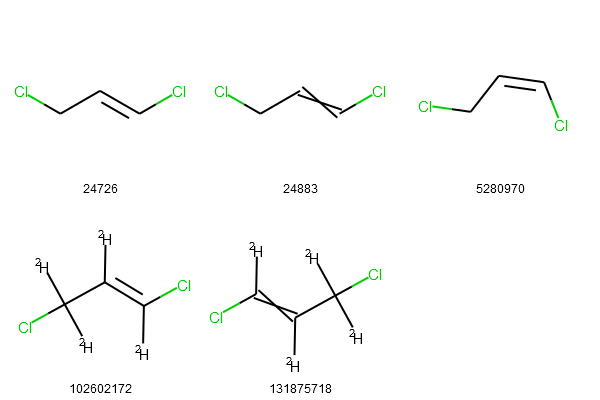

In [1]:
import requests
import time
import io

from rdkit import Chem
from rdkit.Chem import Draw

prolog = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"

mydata = { 'smiles' : 'C(/C=C/Cl)Cl' }
options = [ 'same_stereo_isotope', # This is the default
            'same_stereo',
            'same_isotope',
            'same_connectivity']

for myoption in ( options ) :

    print("#### Identity_type:", myoption)
    
    url = prolog + '/compound/fastidentity/smiles/property/isomericsmiles/csv?identity_type=' + myoption
    res = requests.post(url, data=mydata)
    
    mycids = []
    mysmiles = []
    
    file = io.StringIO(res.text)
    file.readline()               # Skip the first line (column heads)
    
    for line in file :
        
        ( cid_tmp, smiles_tmp ) = line.rstrip().split(',')
        print(cid_tmp, smiles_tmp)
        
        mycids.append( cid_tmp )
        mysmiles.append( smiles_tmp.replace('"',"") )

    mols = []
    
    for x in mysmiles :
        
        mol = Chem.MolFromSmiles(x)
        Chem.FindPotentialStereoBonds(mol)    # Identify potential stereo bonds!
        mols.append(mol)
    
    img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200,200), legends=mycids)
    display(img)
            
    time.sleep(0.2)

**Exercise 1a:** Find compounds that has the same atom connectivity and isotope information as the query molecule.

In [2]:
query = "CC1=CN=C(C(=C1OC)C)C[S@](=O)C2=NC3=C(N2)C=C(C=C3)OC"

For each compound returned from the search, retrieve the following information.
- CID
- Isomeric SMILES string
- chemical synonyms (for simplicity, print only the five synonyms that first occur in the name list retrieved for each compound)
- Structure image


In [5]:
# Retrieving CID and isomeric SMILES
prolog = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"
mydata = {"smiles" : query}
option = "same_isotope"

url = prolog + "/compound/fastidentity/smiles/property/isomericsmiles/csv?identity_type=" + option
res = requests.post(url, data=mydata)

print(res.text)


"CID","IsomericSMILES"
9568614,"CC1=CN=C(C(=C1OC)C)C[S@](=O)C2=NC3=C(N2)C=C(C=C3)OC"
4594,"CC1=CN=C(C(=C1OC)C)CS(=O)C2=NC3=C(N2)C=C(C=C3)OC"
9579578,"CC1=CN=C(C(=C1OC)C)C[S@@](=O)C2=NC3=C(N2)C=C(C=C3)OC"



In [7]:
mycids = []
mysmiles = []
    
file = io.StringIO(res.text)
file.readline()               # Skip the first line (column heads)
    
for line in file :
        
    ( cid_tmp, smiles_tmp ) = line.rstrip().split(',')
    
        
    mycids.append( cid_tmp )
    mysmiles.append( smiles_tmp.replace('"',"") )
print(mycids)
print(mysmiles)

['9568614', '4594', '9579578']
['CC1=CN=C(C(=C1OC)C)C[S@](=O)C2=NC3=C(N2)C=C(C=C3)OC', 'CC1=CN=C(C(=C1OC)C)CS(=O)C2=NC3=C(N2)C=C(C=C3)OC', 'CC1=CN=C(C(=C1OC)C)C[S@@](=O)C2=NC3=C(N2)C=C(C=C3)OC']


In [9]:
# synonyms
for cid in mycids:
    url = prolog + "/compound/cid/" + cid +"/synonyms/txt"
    res = requests.get(url)
    print(cid), 
    print(res.text.split()[0:5])

9568614
['Esomeprazole', '(S)-Omeprazole', '(-)-Omeprazole', '119141-88-7', '(S)-(-)-Omeprazole']
4594
['omeprazole', '73590-58-6', 'Losec', 'Prilosec', 'Antra']
9579578
['(r)-omeprazole', 'Esomeprazole', '119141-89-8', '(R)-5-Methoxy-2-(((4-methoxy-3,5-dimethylpyridin-2-yl)methyl)sulfinyl)-1H-benzo[d]imidazole', '(+)-omeprazole']


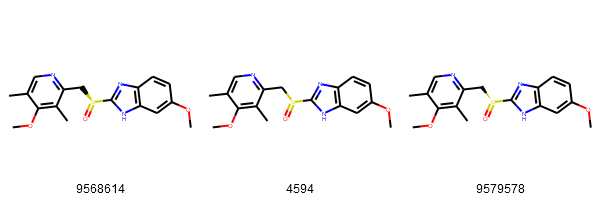

In [13]:
mols = []
for x in mysmiles:
    mol = Chem.MolFromSmiles(x)
    mols.append(mol)
img =  Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200,200), legends=mycids)
display(img)

## 2. Similarity search

PubChem supports 2-dimensional (2-D) and 3-dimensional (3-D) similarity searches.  Because molecular similarity is not a measurable physical observable but a subjective concept, many approaches have been developed to evaluate it.  Detailed discussion on how PubChem quantifyies molecular similarity, read the following LibreTexts page:
    
**Searching PubChem Using a Non-Textual Query** (https://bit.ly/2lPznCo)


The code cell below demonstrates how to perform 2-D and 3-D similarity searches.

In [14]:
mydata = { 'smiles' : "C1COCC(=O)N1C2=CC=C(C=C2)N3C[C@@H](OC3=O)CNC(=O)C4=CC=C(S4)Cl" }
url = prolog + "/compound/fastsimilarity_2d/smiles/cids/txt?Threshold=99"
res = requests.post(url,data=mydata)
cids = res.text.split()

print("# Number of CIDs:", len(cids))
print(cids)

# Number of CIDs: 33
['9875401', '6433119', '11524901', '68152323', '25255944', '25190310', '25164166', '145624246', '145624236', '144489887', '143433422', '123868009', '56598114', '56589668', '11994745', '25190129', '25190130', '25190186', '25190187', '25190188', '25190189', '25190190', '25190248', '25190249', '25190250', '25190251', '25190252', '25190311', '25255845', '25255945', '25255946', '49849874', '133687098']


It is worth mentioning that the parameter name "Threshold" is **case-sensitive**.  If "threshold" is used (rather than "Threshold"), it will be ignored and the default value (0.90) will be used for the parameter.  \[As a matter of fact, all optional parameter names in PUG-REST are case-sensitive.]

In [15]:
url1 = prolog + "/compound/fastsimilarity_2d/smiles/cids/txt?Threshold=95"
url2 = prolog + "/compound/fastsimilarity_2d/smiles/cids/txt?threshold=95"  # "threshold=95" is ignored.

res1 = requests.post(url1,data=mydata)
res2 = requests.post(url2,data=mydata)
cids1 = res1.text.split()
cids2 = res2.text.split()

print("# Number of CIDs:", len(cids1), "vs.", len(cids2))

# Number of CIDs: 227 vs. 1054


It is possible to run 3-D similarity search using PUG-REST.  However, because 3-D similarity search takes much longer than 2-D similarity search, it often exceeds the 30-second time limit and returns a time-out error, especially when the query molecule is big.

In addition, for 3-D similarity search, it is **not** possible to adjust the similarity threshold (that is, the optional "Threshold" parameter does not work).  3-D similarity search uses a shape-Tanimoto (ST) of >=0.80 and a color-Tanimoto (CT) of >=0.50 as a similarity threshold.  Read the libreTexts page for more details (https://bit.ly/2lPznCo).

In [16]:
mydata = { 'smiles' : 'CC(=O)OC1=CC=CC=C1C(=O)O'}
url = prolog + "/compound/fastsimilarity_3d/smiles/cids/txt"
res = requests.post(url, data=mydata)
cids = res.text.split()
print(len(cids))

2496


**Exercise 2a:** Perform 2-D similarity search with the following query, using a threshold of 0.80 and find the macromolecule targets of the assays in which the returned compounds were tested.  You will need to take these steps.

- Run 2-D similarity search using the SMILES string as a query (with Threshold=80).
- Retrieve the AIDs in which any of the returned CIDs was tested "active".
- Retrieve the gene symbols of the targets for the returned AIDs.

In [17]:
query='[C@@H]23C(=O)[C@H](N)C(C)[C@H](CCC1=COC=C1)[C@@]2(C)CCCC3(C)C'

In [26]:
# Run 2-D similarity search using the SMILES string as a query (with Threshold=80).

mydata = {"smiles" : query}
url = prolog + "/compound/fastsimilarity_2d/smiles/cids/txt/?Threshold=80"
res = requests.post(url, data=mydata)
cids = res.text.split()
print(len(cids))

2543


In [36]:
# Retrieve the AIDs in which any of the returned CIDs was tested "active".
cidstring = ",".join(cids)

url = prolog + "/compound/cid/aids/txt?aids_type=active"
res = requests.post(url, data = {"cid":cidstring})
aids = res.text.split()
print(len(aids))

100


In [38]:
# Retrieve the gene symbols of the targets for the returned AIDs.
aidstring = ",".join(aids)
url = prolog + "/assay/aid/targets/GeneSymbol/txt"
res = requests.post(url, data = {"aid":aidstring})
gensym = res.text.split()
print(len(gensym))
print(gensym)

127
['ATP1A1', 'ATP1A2', 'ATP1A3', 'ATP1A4', 'ATP1B1', 'ATP1B2', 'ATP1B3', 'FXYD2', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRM1', 'OPRK1', 'ANPEP', 'ANPEP', 'NR1H4', 'NR1H4', 'ATP1A1', 'ATP1A2', 'ATP1A3', 'ATP1A4', 'ATP1B1', 'ATP1B2', 'ATP1B3', 'FXYD2', 'NR1H4', 'NR1H4', 'NR1I2', 'NR1H4', 'NR1H4', 'NR1H4', 'NR1H4', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'OPRK1', 'HSPB1', 'Htr1a', 'NR1H4', 'NR1H4', 'NR1H4', 'NR1H4', 'NR1I2', 'NR1H4', 'NR1H4', 'NR1H4', 'NR1H4', 'NR1H4', 'NR1H4', 'NR1I2', 'OPRK1', 'HTR2C', 'GALE', 'NR0B1', 'CRHBP', 'CRHR2', 'NR1H4', 'ACHE', 'ADORA1', 'PARP1', 'AGTR1', 'ALOX5', 'AR', 'CACNA1C', 'CCKAR', 'CDK2', 'CHEK1', 'CHRNA1', 'CNR1', 'CRHR1', 'MAPK14', 'DHFR', 'DRD2', 'EDNRA', 'EGFR', 'ESR1', 'F2', 'F10', 'FNTA', 'GABRA1', 'GRIN1', 'GRM2', 'HTR1A', 'ITGA2B', 'KCNJ5', 'M

## 3. Substructure/Superstructure search

When a chemical structure occurs as a part of a bigger chemical structure, the former is called a substructure and the latter is referred to as a superstructure (https://bit.ly/2lPznCo).  PUG-REST supports both substructure and superstructure searches.  For example, below is an example for substructure search using the core structure of antibiotic drugs called cephalosporins as a query (https://en.wikipedia.org/wiki/Cephalosporin). 

In [39]:
query = 'C12(SCC(=C(N1C([C@H]2NC(=O)[*])=O)C(=O)O[H])[*])[H]'

mydata = { 'smiles' : query }
url = prolog + "/compound/fastsubstructure/smiles/cids/txt?Stereo=exact"
res = requests.post(url, data=mydata)
cids = res.text.split()

print("# Number of CIDs:", len(cids))
#print(cids)

# Number of CIDs: 25571


An important thing to remember about substructure search is that, if the query structure is not specific enough (that is, not big enough), it will return too many hits for the PubChem server can handle.  For example, if you perform substructure search using the "C-C" as a query, it will give you an error, because PubChem has ~96 million (organic) compounds with more than two carbon atoms and most of them will have the "C-C" unit. Therefore, if you get an "time-out" error while doing substructure search, consider providing more specific structure as an input query.

**Exercise 3a:** Below is the SMILES string for a HCV (Hepatitis C Virus) drug (Sovaldi).  Perform substructure search using this SMILES string as a query, identify compounds that are mentioned in patent documents, and create a list of the patent documents that mentioning them.

- Use the default options for substructure search.
- Use the "XRefs" operation to retrieve Patent IDs associated with the returned compounds.
- For simplicity, ignore the CID-Patent ID mapping.  (That is, no need to track which CID is associated with which patent document.)

In [40]:
query="C[C@@H](C(=O)OC(C)C)N[P@](=O)(OC[C@@H]1[C@H]([C@@]([C@@H](O1)N2C=CC(=O)NC2=O)(C)F)O)OC3=CC=CC=C3"

In [41]:
# Substructure search (default options)
mydata = { 'smiles' : query }
url = prolog + "/compound/fastsubstructure/smiles/cids/txt"
res = requests.post(url, data=mydata)
cids = res.text.split()

print("# Number of CIDs:", len(cids))

# Number of CIDs: 774


In [44]:
# Retrieve Patent IDs associated
cidstring = ",".join(cids)
url = prolog + "/compound/cid/xrefs/PatentID/txt"
res = requests.post(url, data = { "cid" : cidstring})
patentids = res.text.split()

print("# Number of patent IDs:", len(patentids))


# Number of patent IDs: 2311


## 4. Molecular formula search

Strictly speaking, molecular formula search is not structure search, but its PUG-REST request URL is constructed in a similar way to structure searches like identity, similarity, and substructure/superstructure searches.

In [45]:
query = 'C22H28FN3O6S'    # Molecular formula for Crestor (Rosuvastatin: CID 446157)

url = prolog + "/compound/fastformula/"+ query + "/cids/txt"
res = requests.get(url)
cids = res.text.split()
print("# Number  of CIDs:", len(cids))
#print(cids)

# Number  of CIDs: 197


It is possible to allow other elements to be present in addition to those specified by the query formula, as shown in the following example.


In [46]:
url = prolog + "/compound/fastformula/"+ query + "/cids/txt?AllowOtherElements=true"
res = requests.get(url)
cids = res.text.split()
print("# Number of CIDs:", len(cids))
#print(cids)

# Number of CIDs: 220


**Exercise 4a:**  The general molecular formula for alcohols is $C_{n}H_{(2n+2)}O$ \[for example, CH4O (methanol), C2H6O (ethanol), C3H8O (propanol), etc].  Run molecular formula search using this general formula for n=1 through 20 and retrieve the XLogP values of the returned compounds for each value of n.  Print the minimum and maximum XLogP values for each n value.

In [49]:
# Write your code in this cell.
formulae = []
for n in range(1,21):
    formula = "C" + str(n) + "H" + str(2*n +2) + "O"
    formulae.append(formula)
    
print(formulae)

['C1H4O', 'C2H6O', 'C3H8O', 'C4H10O', 'C5H12O', 'C6H14O', 'C7H16O', 'C8H18O', 'C9H20O', 'C10H22O', 'C11H24O', 'C12H26O', 'C13H28O', 'C14H30O', 'C15H32O', 'C16H34O', 'C17H36O', 'C18H38O', 'C19H40O', 'C20H42O']


In [55]:
cids = []
for formula in formulae:
    url = prolog + "/compound/fastformula/" + formula + "/cids/txt"
    res = requests.get(url)
    time.sleep(0.2)
    cids.append(res.text.split())

In [61]:
xlogp = []
for n in cids:
    cidstring = ",".join(n)
    url = prolog + "/compound/cid/property/XLogP/txt"
    res = requests.post(url, data={"cid":cidstring})
    xlogp.append(res.text.split())

In [63]:
# converting string in list to float
for n in xlogp:
    n = list(map(float, n))

xlogpmin = []
xlogpmax = []
for n in xlogp:
    xlogpmin.append(min(n))
    xlogpmax.append(max(n))


In [68]:
print("n, formula, XLogP(min), XLogP(max)")
for n in range(20):
    print(n+1, formulae[n], xlogpmin[n], xlogpmax[n])

n, formula, XLogP(min), XLogP(max)
1 C1H4O -0.5 -0.500
2 C2H6O -0.1 0.1
3 C3H8O 0.3 0.400
4 C4H10O 0.5 1.200
5 C5H12O 0.900 1.700
6 C6H14O 1.4 2.000
7 C7H16O 1.8 2.900
8 C8H18O 2.0 3.500
9 C9H20O 2.6 4.300
10 C10H22O 2.9 4.800
11 C11H24O 3.4 5.100
12 C12H26O 3.7 5.400
13 C13H28O 4.2 6.100
14 C14H30O 4.6 6.700
15 C15H32O 5.0 7.200
16 C16H34O 5.4 7.800
17 C17H36O 5.9 8.300
18 C18H38O 6.2 8.600
19 C19H40O 6.7 9.100
20 C20H42O 7.0 9.500
